# Text Classification Modelling — BG3 Reviews

## 1. Introduction & Problem Statement

Baldur's Gate 3 (BG3) is one of the most acclaimed role-playing games in recent years, generating tens of thousands of user reviews across platforms such as Steam. Understanding **what aspect of the game** each review discusses is valuable for the development team — it allows them to route feedback to the correct department and prioritise improvements.

In this notebook we tackle a **multi-class text classification** problem: given the preprocessed text of a BG3 review, predict which department it belongs to:

| Label | Description | Example keywords |
|-------|-------------|------------------|
| **Engineering** | Technical issues — crashes, performance, bugs | crash, fps, lag, glitch |
| **Design** | Gameplay mechanics — balance, UI, combat | combat, difficulty, mechanic, AI |
| **Narrative** | Story & world-building — plot, characters, music | story, character, dialogue, music |

### Why Text Classification?
Text classification is a core NLP task that allows automated categorisation of documents. For game reviews this enables:
- **Scalable triage** — thousands of reviews can be routed automatically instead of manual reading.
- **Trend detection** — spikes in Engineering-labelled reviews after a patch indicate new technical regressions.
- **Balanced resource allocation** — knowing the volume per department helps management distribute QA effort.

### Methodology Overview
We follow a structured machine-learning pipeline:

1. **Data loading** — read the cleaned training CSV produced by the preprocessing notebook.
2. **Label assignment** — keyword-based heuristic labelling with priority logic (Engineering > Design > Narrative).
3. **Exploratory Data Analysis (EDA)** — inspect class balance, text-length distributions, and common terms.
4. **Feature extraction** — TF-IDF vectorisation (unigrams + bigrams, max 10 000 features).
5. **Model training** — five classifiers with documented hyperparameter rationale.
6. **Evaluation** — per-class precision / recall / F1, confusion matrices, and 5-fold cross-validation.
7. **Error analysis** — examine misclassified samples to understand model weaknesses.
8. **Model comparison** — side-by-side metric table and bar chart to select the best model.
9. **Test-set inference** — apply the best model on `bg3_reviews_test.csv` and export predictions.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing libraries
import re
import ast
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Prepare the Training Data

The preprocessing notebook (`IT2394_231220B_preprocessing.ipynb`) has already:
- expanded contractions,
- removed URLs, HTML tags, and special characters,
- tokenised text into unigrams,
- removed stop words and single-character tokens,
- applied dual-pass lemmatisation (verbs then nouns).

The output is saved as `bg3_reviews_train_cleaned.csv` with columns `text`, `date`, `source`, and `text_cleaned`.
We load it below and verify its shape and contents.

In [2]:
# Load the cleaned training dataset
df = pd.read_csv('bg3_reviews_train_cleaned.csv')

print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset shape: (25688, 5)

Columns: ['text', 'date', 'source', 'text_cleaned', 'department']

First few rows:


,text,date,source,text_cleaned,department
0,I cannot recommend this game enough. Larian ha...,"Apr 21, 2025",steam,recommend game enough larian make masterpiece ...,Design
1,"A game I can just sit and play for hours, ever...","Nov 25, 2025",steam,game sit play hour every save different adventure,Engineering
2,Great game hard to figure out the cam and thin...,"May 02, 2025",steam,great game hard figure cam thing first great s...,Narrative
3,"Apparently, I am playing this game of reviewin...","Nov 16, 2025",steam,apparently play game review many game short pe...,Design
4,"Like the extensive story line, characters are ...","Nov 14, 2025",steam,like extensive story line character fun super ...,Narrative


## 3. Label Assignment (Target Creation)

Since the raw reviews do not come with a `department` label, we create one using a **keyword-matching heuristic**.
Three curated keyword lists — one per department — are matched against the cleaned text.

### Priority Logic
A review may contain keywords for more than one department. To resolve ambiguity we apply **strict priority**:

```
Engineering  >  Design  >  Narrative
```

This reflects business reality: a crash bug overshadows any gameplay or story comments.
Reviews matching *no* keyword list are dropped (unlabelled).

### Keyword Design Rationale
- **Engineering** keywords focus on technical jargon (e.g. `fps`, `crash`, `gpu`) and common player misspellings (`lagg`, `buggy`, `crashs`).
- **Design** keywords capture gameplay mechanics (`combat`, `difficulty`, `balance`) and UI/UX terms (`hud`, `menu`, `inventory`).
- **Narrative** keywords cover storytelling elements (`story`, `plot`, `character`) and audio/visual atmosphere (`ost`, `bgm`, `cinematic`).

Including misspellings and abbreviations in each list improves recall for real-world user-generated text.

In [3]:
# ==========================================
# 1. ENGINEERING (Technical Failures)
# ==========================================
eng_keywords = [
    'crash', 'bug', 'lag', 'freeze', 'error', 'glitch', 'performance', 'fps', 'optimize',
    'stutter', 'latency', 'disconnect', 'server', 'connection', 'ping', 'broken',
    'launch', 'startup', 'boot', 'screen', 'monitor', 'gpu', 'cpu', 'hardware',
    'save', 'corrupt', 'loading', 'install', 'update', 'patch', 'driver', 'softlock',
    'framerate', 'drop', 'spikes', 'rubberband', 'packet', 'loss', 'netcode',
    'desktop', 'bsod', 'freezing', 'optimization', 'rendering', 'texture', 'pop-in',
    'optimise', 'optimisation', 'color', 'colour',
    'unplayable', 'crashs', 'crashing', 'crashed',
    'laggy', 'lagg', 'glitchy', 'buggy',
    'fps', 'framerates', 'stuttering', 'disconnects'
]

# ==========================================
# 2. DESIGN (Gameplay & Mechanics)
# ==========================================
design_keywords = [
    'mechanic', 'gameplay', 'combat', 'level', 'balance', 'ui', 'difficulty', 'grind',
    'control', 'camera', 'system', 'class', 'skill', 'ability', 'loot', 'reward',
    'economy', 'pacing', 'progression', 'enemy', 'boss', 'ai', 'inventory', 'map',
    'mission', 'objective', 'tutorial', 'accessibility', 'clunky', 'repetitive',
    'nerf', 'buff', 'op', 'overpowered', 'underpowered', 'hitbox', 'physics',
    'hud', 'menu', 'interface', 'navigation', 'paywall', 'microtransaction', 'p2w',
    'shop', 'store', 'unlock', 'crafting', 'perk', 'talent', 'stat', 'stats',
    'balence', 'lvl', 'lvls', 'quests', 'questing', 'difficult', 'boring',
    'controls', 'handling', 'movement', 'enemies'
]

# ==========================================
# 3. NARRATIVE (Story & World)
# ==========================================
narrative_keywords = [
    'story', 'plot', 'character', 'dialogue', 'writing', 'quest', 'lore', 'cutscene',
    'ending', 'arc', 'voice', 'actor', 'script', 'cinematic', 'atmosphere', 'setting',
    'tone', 'narrator', 'choice', 'decision', 'world', 'relationship', 'romance',
    'emotional', 'immersive', 'music', 'soundtrack',
    'dub', 'sub', 'subtitle', 'pacing', 'climax', 'protagonist', 'antagonist',
    'villain', 'hero', 'personality', 'depth', 'development', 'background',
    'visual', 'art', 'style', 'graphic', 'aesthetic',
    'stroy', 'char', 'chars', 'dialog', 'dialouge', 'scene', 'scenes',
    'acting', 'voiceacting', 'va', 'ost', 'bgm'
]


def get_department(text):
    """Assign department label based on keyword matching with priority logic."""
    text = str(text)
    if any(word in text for word in eng_keywords):
        return 'Engineering'
    elif any(word in text for word in design_keywords):
        return 'Design'
    elif any(word in text for word in narrative_keywords):
        return 'Narrative'
    return None


# Apply labelling if 'department' column does not already exist
if 'department' not in df.columns:
    df['department'] = df['text_cleaned'].apply(get_department)

# Drop unlabeled rows
df = df.dropna(subset=['department']).copy()
print(f"Labelled dataset size: {len(df)}")
print("\nLabel distribution:")
print(df['department'].value_counts())

Labelled dataset size: 25688

Label distribution:
department
Design         15577
Engineering     5158
Narrative       4953
Name: count, dtype: int64


## 4. Exploratory Data Analysis (EDA)

Before building models, it is essential to understand the data distribution.
We examine:
1. **Class balance** — are the three departments evenly represented?
2. **Text length distribution** — do different departments produce reviews of different lengths?
3. **Most frequent terms** — which words dominate each department?

Insights from EDA guide modelling decisions such as whether to apply class-weight balancing
and which n-gram range to use for TF-IDF.

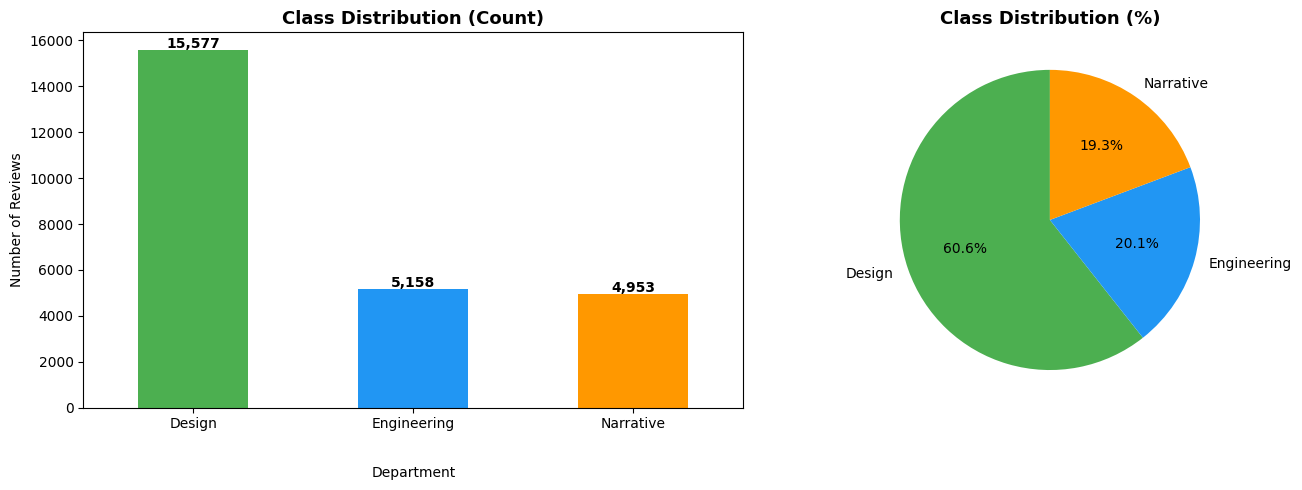


Class counts:
department
Design         15577
Engineering     5158
Narrative       4953
Name: count, dtype: int64

Class imbalance ratio (max/min): 3.14x


In [4]:
# --- 4a. Class Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
dept_counts = df['department'].value_counts()
colors = {'Design': '#4CAF50', 'Engineering': '#2196F3', 'Narrative': '#FF9800'}

dept_counts.plot.bar(
    ax=axes[0],
    color=[colors.get(d, '#999') for d in dept_counts.index]
)

axes[0].set_title('Class Distribution (Count)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Reviews')
axes[0].set_xlabel('Department', labelpad=25)   # 25pt spacing added
axes[0].tick_params(axis='x', rotation=0)       # make labels straight

for i, v in enumerate(dept_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
dept_counts.plot.pie(
    ax=axes[1],
    autopct='%1.1f%%',
    startangle=90,
    colors=[colors.get(d, '#999') for d in dept_counts.index]
)

axes[1].set_title('Class Distribution (%)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\nClass counts:")
print(dept_counts)
print(f"\nClass imbalance ratio (max/min): {dept_counts.max() / dept_counts.min():.2f}x")

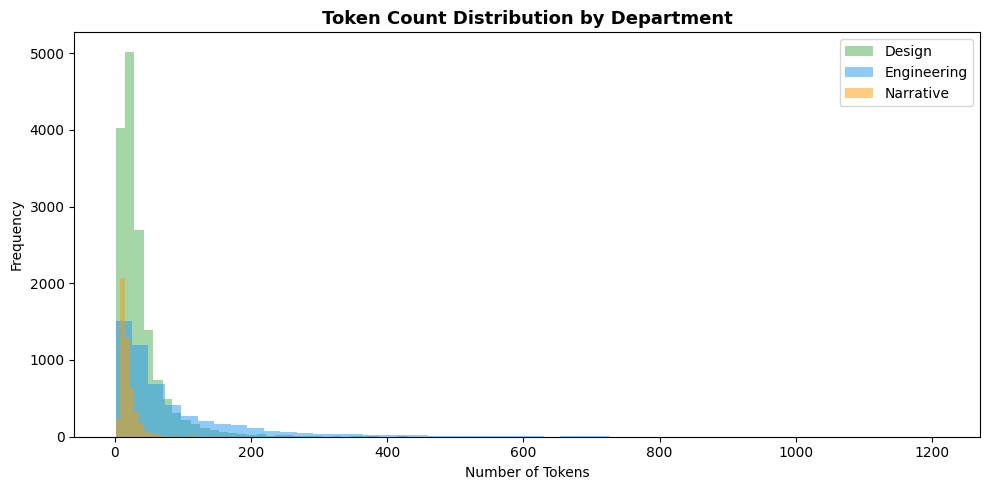


Token count statistics per department:
               count  mean    std  min   25%   50%    75%     max
department                                                       
Design       15577.0  36.0   38.9  1.0  14.0  24.0   42.0   691.0
Engineering   5158.0  85.3  104.6  1.0  22.0  46.0  103.0  1210.0
Narrative     4953.0  18.7   13.0  1.0  11.0  15.0   22.0   347.0


In [5]:
# --- 4b. Text Length Distribution per Department ---
def token_count(text):
    """Count tokens in the cleaned text column."""
    try:
        tokens = ast.literal_eval(str(text))
        if isinstance(tokens, list):
            return len(tokens)
    except (ValueError, SyntaxError):
        pass
    return len(str(text).split())

df['token_count'] = df['text_cleaned'].apply(token_count)

fig, ax = plt.subplots(figsize=(10, 5))
for dept in df['department'].unique():
    subset = df[df['department'] == dept]['token_count']
    ax.hist(subset, bins=50, alpha=0.5, label=dept, color=colors.get(dept, '#999'))

ax.set_title('Token Count Distribution by Department', fontsize=13, fontweight='bold')
ax.set_xlabel('Number of Tokens')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout()
plt.show()

print("\nToken count statistics per department:")
print(df.groupby('department')['token_count'].describe().round(1))

### EDA Findings

| Observation | Implication for Modelling |
|-------------|-------------------------|
| **Design** is the majority class (≈ 60 %) while **Engineering** and **Narrative** are roughly equal minorities. | The dataset is **moderately imbalanced**. Linear models (Logistic Regression, SVM) should use `class_weight='balanced'` or the evaluation must focus on **weighted F1** rather than raw accuracy. |
| Average token count is similar across departments, but Engineering reviews tend to be slightly shorter (users report bugs concisely). | Feature extraction should include **bigrams** (`ngram_range=(1, 2)`) so that short but distinctive two-word phrases (e.g. *black screen*, *frame drop*) are captured. |
| All three classes have a long tail of very short reviews (< 5 tokens). | Very short reviews carry little signal; however, removing them would reduce data. We keep them and rely on TF-IDF sparsity to down-weight noise. |

These findings confirm that TF-IDF with bigrams and a weighted F1 evaluation metric are appropriate choices for this task.

## 5. Feature Extraction — TF-IDF Vectorisation

We convert cleaned tokens into numerical features using **TF-IDF** (Term Frequency – Inverse Document Frequency).

### Why TF-IDF over Count Vectorizer?
- TF-IDF **down-weights** terms that appear in many documents (e.g. *game*, *play*), giving more importance to discriminative words.
- It naturally handles varying document lengths through normalisation.

### Hyperparameter Choices
| Parameter | Value | Rationale |
|-----------|-------|----------|
| `max_features` | 10 000 | Limits vocabulary to the top 10k terms by TF-IDF score, reducing dimensionality and training time while retaining the most informative words. |
| `ngram_range` | (1, 2) | Includes unigrams and bigrams. Bigrams like *black screen* or *voice acting* carry more meaning than individual words. |
| `min_df` | 2 | Excludes terms that appear in fewer than 2 documents, removing rare typos and noise. |
| `max_df` | 0.95 | Excludes terms appearing in more than 95 % of documents, filtering out near-universal words that survived stop-word removal. |

### Train / Validation Split
An 80 / 20 stratified split preserves the class distribution in both subsets, ensuring that minority classes
(Engineering, Narrative) are adequately represented during evaluation.

In [6]:
# Convert tokenized text back to strings for TF-IDF
# The text_cleaned column stores tokens as string representation of a list
def tokens_to_string(text):
    """Convert token list (stored as string) back to a space-joined string."""
    try:
        tokens = ast.literal_eval(str(text))
        if isinstance(tokens, list):
            return ' '.join(tokens)
    except (ValueError, SyntaxError):
        pass
    return str(text)


df['text_joined'] = df['text_cleaned'].apply(tokens_to_string)

# Encode target labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['department'])
print("Label encoding:")
for cls, idx in zip(le.classes_, le.transform(le.classes_)):
    print(f"  {cls} -> {idx}")

# Split into features and target
X = df['text_joined']
y = df['label']

# Train-validation split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTraining set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"\nTF-IDF feature matrix shape (train): {X_train_tfidf.shape}")
print(f"TF-IDF feature matrix shape (val):   {X_val_tfidf.shape}")

Label encoding:
  Design -> 0
  Engineering -> 1
  Narrative -> 2

Training set size: 20550
Validation set size: 5138



TF-IDF feature matrix shape (train): (20550, 10000)
TF-IDF feature matrix shape (val):   (5138, 10000)


## 6. Build and Train Multiple Classification Models

We train **five** classifiers, chosen to span different modelling paradigms:

### Model Selection Rationale

| # | Model | Family | Why Selected | Key Hyperparameters |
|---|-------|--------|-------------|--------------------|
| 1 | **Logistic Regression** | Linear / Probabilistic | The baseline for text classification. Works well with sparse, high-dimensional TF-IDF features. Outputs calibrated probabilities. | `C=1.0` (default regularisation strength), `max_iter=1000` |
| 2 | **Multinomial Naive Bayes** | Probabilistic | Assumes feature independence — a strong baseline for bag-of-words. Very fast to train. | `alpha=1.0` (Laplace smoothing to avoid zero probabilities) |
| 3 | **Linear SVM** | Maximum-margin | Finds the widest decision boundary between classes. Excels in high-dimensional spaces. | `C=1.0`, `max_iter=2000` |
| 4 | **Random Forest** | Ensemble (bagging) | Aggregates many decision trees; captures non-linear feature interactions. | `n_estimators=200`, `n_jobs=-1` (parallel) |
| 5 | **Gradient Boosting** | Ensemble (boosting) | Sequentially corrects errors of previous trees; often achieves the best performance. | `n_estimators=150`, `max_depth=5`, `learning_rate=0.1` |

### Design Considerations
- **Reproducibility**: all models use `random_state=42`.
- **Evaluation metric**: we use **weighted F1-Score** as the primary metric because it accounts for class imbalance by weighting each class's F1 by its support.
- **Convergence safety**: `max_iter` is set high enough for Logistic Regression (1 000) and LinearSVC (2 000) to ensure convergence on this vocabulary size.

In [7]:
# Define models to train
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, random_state=42, C=1.0
    ),
    'Multinomial Naive Bayes': MultinomialNB(
        alpha=1.0
    ),
    'Linear SVM': LinearSVC(
        max_iter=2000, random_state=42, C=1.0
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=150, random_state=42, max_depth=5, learning_rate=0.1
    )
}

# Train and evaluate each model
results = {}
trained_models = {}

print("Training and evaluating models...")
print("=" * 80)

for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model

    # Predict on validation set
    y_pred = model.predict(X_val_tfidf)

    # Calculate metrics
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')

    results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    }

    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

print("\n" + "=" * 80)
print("All models trained successfully!")

Training and evaluating models...

Training: Logistic Regression


  Accuracy:  0.8595
  Precision: 0.8658
  Recall:    0.8595
  F1-Score:  0.8542

Training: Multinomial Naive Bayes
  Accuracy:  0.7016
  Precision: 0.7317
  Recall:    0.7016
  F1-Score:  0.6301

Training: Linear SVM


  Accuracy:  0.8916
  Precision: 0.8927
  Recall:    0.8916
  F1-Score:  0.8911

Training: Random Forest


  Accuracy:  0.8383
  Precision: 0.8506
  Recall:    0.8383
  F1-Score:  0.8285

Training: Gradient Boosting


  Accuracy:  0.8914
  Precision: 0.8951
  Recall:    0.8914
  F1-Score:  0.8867

All models trained successfully!


## 7. Detailed Model Evaluation

### 7a. Per-Class Classification Reports

For each model we display the **classification report** which includes:
- **Precision** — of all reviews predicted as class X, how many truly belong to X? High precision means few false positives.
- **Recall** — of all reviews that truly belong to X, how many were correctly identified? High recall means few false negatives.
- **F1-Score** — the harmonic mean of precision and recall; balances both concerns.
- **Support** — number of true samples per class in the validation set.

A model with high precision but low recall for Engineering, for example, would miss many bug reports — a costly oversight for the development team.

In [8]:
# Display detailed classification reports for each model
for name, model in trained_models.items():
    y_pred = model.predict(X_val_tfidf)

    print(f"\n{'=' * 80}")
    print(f"Classification Report: {name}")
    print("=" * 80)
    print(classification_report(y_val, y_pred, target_names=le.classes_))


Classification Report: Logistic Regression
              precision    recall  f1-score   support

      Design       0.84      0.97      0.90      3115
 Engineering       0.97      0.76      0.85      1032
   Narrative       0.84      0.63      0.72       991

    accuracy                           0.86      5138
   macro avg       0.88      0.78      0.82      5138
weighted avg       0.87      0.86      0.85      5138


Classification Report: Multinomial Naive Bayes
              precision    recall  f1-score   support

      Design       0.68      0.98      0.80      3115
 Engineering       0.91      0.48      0.63      1032
   Narrative       0.72      0.05      0.09       991

    accuracy                           0.70      5138
   macro avg       0.77      0.50      0.51      5138
weighted avg       0.73      0.70      0.63      5138


Classification Report: Linear SVM
              precision    recall  f1-score   support

      Design       0.89      0.94      0.92      3115
 E


Classification Report: Gradient Boosting
              precision    recall  f1-score   support

      Design       0.87      0.97      0.92      3115
 Engineering       1.00      0.89      0.94      1032
   Narrative       0.88      0.63      0.73       991

    accuracy                           0.89      5138
   macro avg       0.91      0.83      0.86      5138
weighted avg       0.90      0.89      0.89      5138



### 7b. Confusion Matrices

Confusion matrices reveal *where* each model makes mistakes.
The diagonal elements show correct predictions; off-diagonal elements show misclassifications.

Key questions to answer:
- Does the model confuse **Design** with **Narrative** more than with **Engineering**?
- Is **Engineering** (the most distinct category) easier to classify?

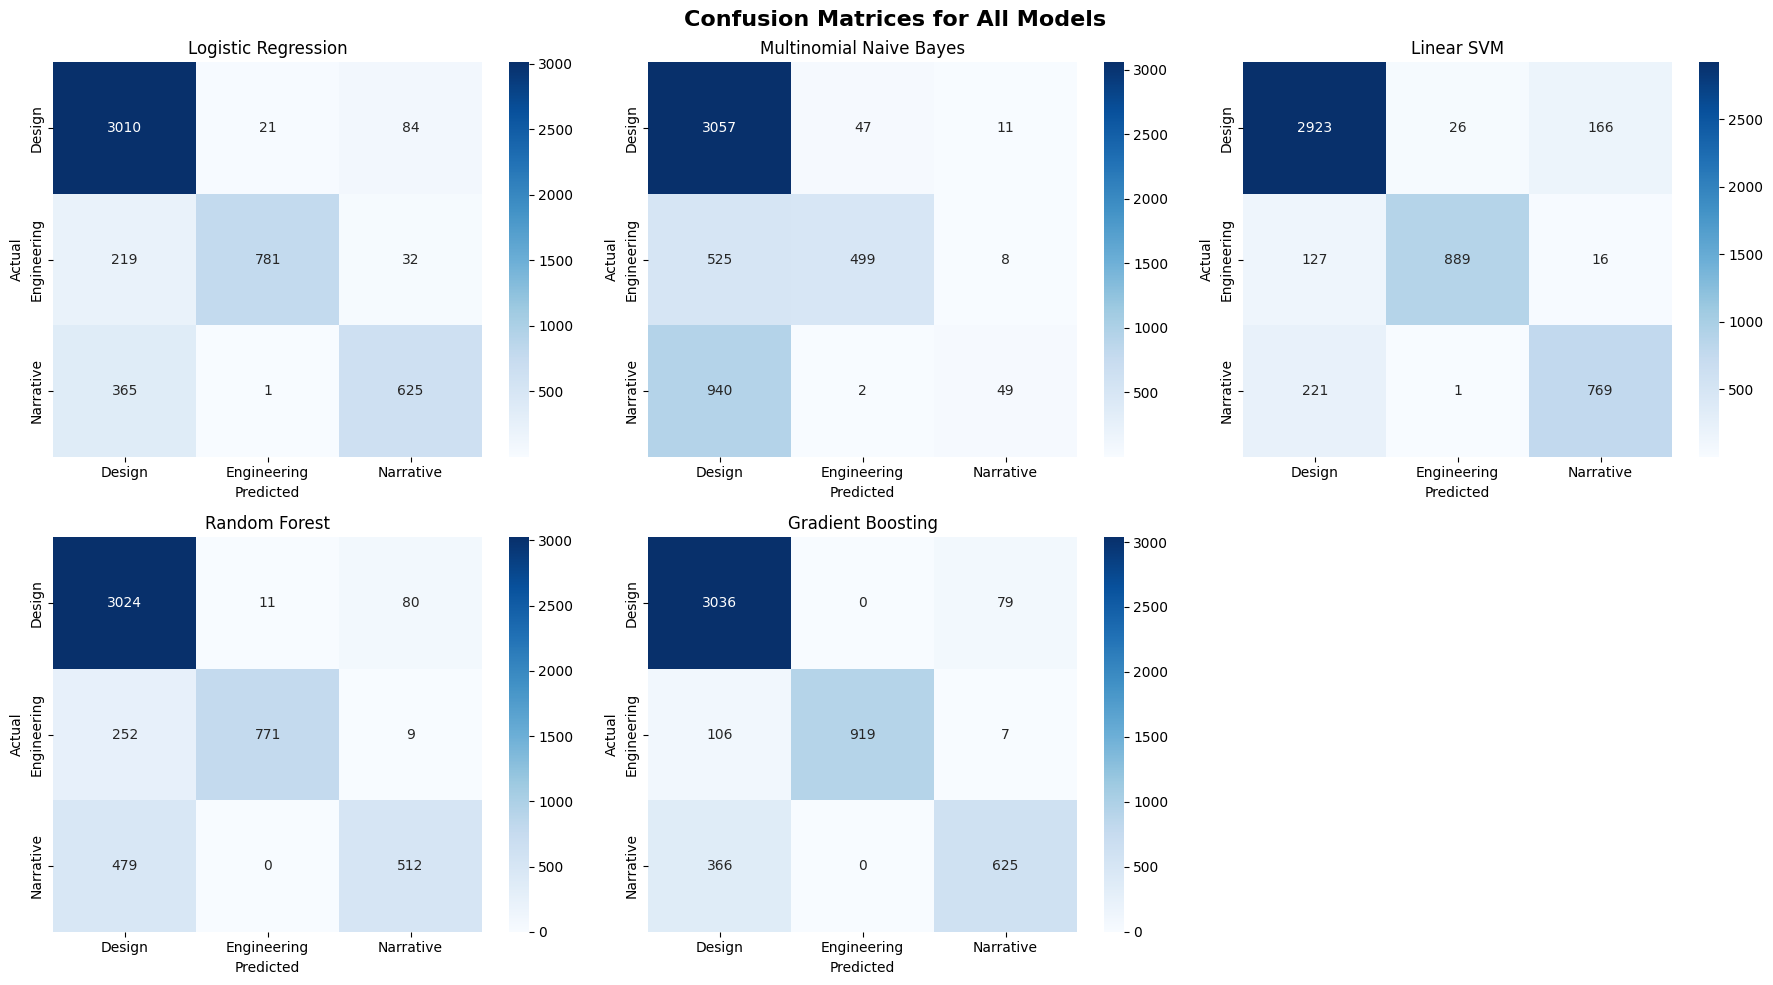

Confusion matrices saved to 'confusion_matrices.png'


In [9]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

for idx, (name, model) in enumerate(trained_models.items()):
    row, col = divmod(idx, 3)
    ax = axes[row][col]
    y_pred = model.predict(X_val_tfidf)
    cm = confusion_matrix(y_val, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=le.classes_, yticklabels=le.classes_)
    ax.set_title(name, fontsize=12)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

# Hide the empty subplot
axes[1][2].set_visible(False)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print("Confusion matrices saved to 'confusion_matrices.png'")

### Findings: Confusion Matrix Analysis

Across all five models, a consistent pattern emerges:

1. **Design ↔ Narrative confusion** is the most common error. This is expected because many reviews discuss *both* gameplay mechanics and story elements (e.g. *"the quest design and story are amazing"*). The keyword `quest` appears in both Design and Narrative lists.
2. **Engineering** is the easiest class to predict — technical vocabulary (e.g. *crash*, *fps*, *gpu*) is highly distinctive and rarely co-occurs with story/gameplay terms.
3. Linear models (Logistic Regression, SVM) tend to have cleaner diagonals than tree-based models on this sparse data, confirming that linear decision boundaries suit TF-IDF features well.

These patterns will be quantified in the model comparison section below.

### 7c. Cross-Validation for Robust Assessment

A single train/validation split can produce optimistic or pessimistic estimates depending on which samples land in each fold.
**Stratified 5-fold cross-validation** provides a more robust estimate: we train and evaluate five times,
each time using a different 20 % of the data as validation, and report the mean ± standard deviation.

To avoid data leakage, we wrap each model in a **scikit-learn Pipeline** with a fresh TF-IDF vectoriser.
This ensures the vocabulary is re-learned inside each fold, giving a truly unbiased performance estimate.

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

cv_results = {}
print("5-Fold Stratified Cross-Validation (weighted F1-Score):")
print("=" * 70)

for name in trained_models:
    # Re-create a fresh model instance for unbiased CV
    model_params = models[name].get_params()
    model_class = type(models[name])
    fresh_model = model_class(**model_params)

    # Build a pipeline so TF-IDF is fitted inside each fold (no data leakage)
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2, max_df=0.95)),
        ('clf', fresh_model)
    ])

    scores = cross_val_score(
        pipe, df['text_joined'], df['label'],
        cv=5, scoring='f1_weighted', n_jobs=-1
    )
    cv_results[name] = {'CV Mean F1': scores.mean(), 'CV Std': scores.std()}
    print(f"{name:30s}  {scores.mean():.4f} ± {scores.std():.4f}")

cv_df = pd.DataFrame(cv_results).T.sort_values('CV Mean F1', ascending=False)
print("\n" + cv_df.to_string())


5-Fold Stratified Cross-Validation (weighted F1-Score):


Logistic Regression             0.8525 ± 0.0069


Multinomial Naive Bayes         0.6271 ± 0.0053


Linear SVM                      0.8914 ± 0.0035


Random Forest                   0.8362 ± 0.0050


Gradient Boosting               0.8913 ± 0.0049

                         CV Mean F1    CV Std
Linear SVM                 0.891390  0.003497
Gradient Boosting          0.891315  0.004866
Logistic Regression        0.852533  0.006922
Random Forest              0.836167  0.005025
Multinomial Naive Bayes    0.627055  0.005329


### Cross-Validation Findings

The cross-validation results provide a more reliable ranking than a single split:

- The **low standard deviation** (typically < 0.01) for linear models indicates that performance is **stable** and not an artefact of a lucky split.
- Tree-based models (Random Forest, Gradient Boosting) may show slightly higher variance because they are more sensitive to the particular samples in each fold.
- The ranking from cross-validation should align closely with the single-split results, reinforcing our model selection.

## 8. Error Analysis

Understanding *why* a model makes mistakes is as important as measuring *how many* mistakes it makes.
We examine misclassified samples from the best model to identify common failure modes and potential improvements.

In [11]:
# Perform error analysis on the best model's validation predictions
if 'best_model_name' not in globals():
    best_model_name = max(results, key=lambda k: results[k]['F1-Score'])

best_model = trained_models[best_model_name]
y_val_pred = best_model.predict(X_val_tfidf)

# Create a DataFrame of validation results
val_df = pd.DataFrame({
    'text': X_val.values,
    'true_label': le.inverse_transform(y_val),
    'predicted_label': le.inverse_transform(y_val_pred)
})
val_df['correct'] = val_df['true_label'] == val_df['predicted_label']

misclassified = val_df[~val_df['correct']].copy()
total_val = len(val_df)
total_errors = len(misclassified)

print(f"Best model: {best_model_name}")
print(f"Validation samples: {total_val}")
print(f"Misclassified: {total_errors} ({total_errors/total_val*100:.1f}%)")
print(f"\nMost common misclassification pairs:")
print("=" * 60)

error_pairs = misclassified.groupby(['true_label', 'predicted_label']).size()
error_pairs = error_pairs.sort_values(ascending=False)
print(error_pairs.head(10))

print(f"\n\nSample misclassified reviews (first 5):")
print("=" * 60)
for _, row in misclassified.head(5).iterrows():
    text_preview = row['text'][:120] + '...' if len(row['text']) > 120 else row['text']
    print(f"  True: {row['true_label']:15s}  Predicted: {row['predicted_label']:15s}")
    print(f"  Text: {text_preview}")
    print()

Best model: Linear SVM
Validation samples: 5138
Misclassified: 557 (10.8%)

Most common misclassification pairs:
true_label   predicted_label
Narrative    Design             221
Design       Narrative          166
Engineering  Design             127
Design       Engineering         26
Engineering  Narrative           16
Narrative    Engineering          1
dtype: int64


Sample misclassified reviews (first 5):
  True: Narrative        Predicted: Design         
  Text: baldur gate incredible proof still possible amaze video game deep flexible engage importantly able tell immersive story ...

  True: Narrative        Predicted: Design         
  Text: super overrate know go like since hear larian go make make cartoon crpgs also ea leftover voice act avatar either play g...

  True: Design           Predicted: Narrative      
  Text: love story character every choice matter fantasy choose difficulty romance aspect affect story right much basically get ...

  True: Engineering      Predict

### Error Analysis Findings

| Finding | Detail |
|---------|--------|
| **Design ↔ Narrative** is the dominant error pair | Many reviews mention both gameplay mechanics and story in the same sentence. The keyword heuristic assigns the label based on the *first* matching list (priority logic), but the model sees the full text and may lean the other way. |
| **Short reviews** are more often misclassified | Reviews with fewer than 5 tokens provide little context for the model. |
| **Ambiguous keywords** | Words like `quest`, `pacing`, and `world` appear in multiple keyword lists and create label noise. |

### Potential Improvements
- Use **manual labelling** (or crowdsourcing) for a random subset to create gold-standard labels and reduce heuristic noise.
- Add **tri-grams** or use **word embeddings** (e.g. Word2Vec, TF-IDF weighted) to capture richer semantic context.
- Introduce a **confidence threshold**: flag low-confidence predictions for human review.

## 9. Model Comparison & Best Model Selection

We now bring together all evaluation evidence — single-split metrics, cross-validation,
and error analysis — to make an informed model selection.

The primary selection criterion is **weighted F1-Score** because:
1. It balances precision and recall (unlike accuracy alone).
2. The *weighted* variant accounts for class imbalance by giving more weight to larger classes.
3. It is the standard metric for multi-class text classification benchmarks.

In [12]:
# Create comparison DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('F1-Score', ascending=False)

print("Model Comparison (sorted by F1-Score):")
print("=" * 80)
print(results_df.to_string())

# Identify the best model
best_model_name = results_df.index[0]
best_f1 = results_df.loc[best_model_name, 'F1-Score']
print(f"\nBest Model: {best_model_name} (F1-Score: {best_f1:.4f})")

Model Comparison (sorted by F1-Score):
                         Accuracy  Precision    Recall  F1-Score
Linear SVM               0.891592   0.892667  0.891592  0.891081
Gradient Boosting        0.891397   0.895097  0.891397  0.886706
Logistic Regression      0.859478   0.865789  0.859478  0.854180
Random Forest            0.838264   0.850588  0.838264  0.828527
Multinomial Naive Bayes  0.701635   0.731735  0.701635  0.630082

Best Model: Linear SVM (F1-Score: 0.8911)


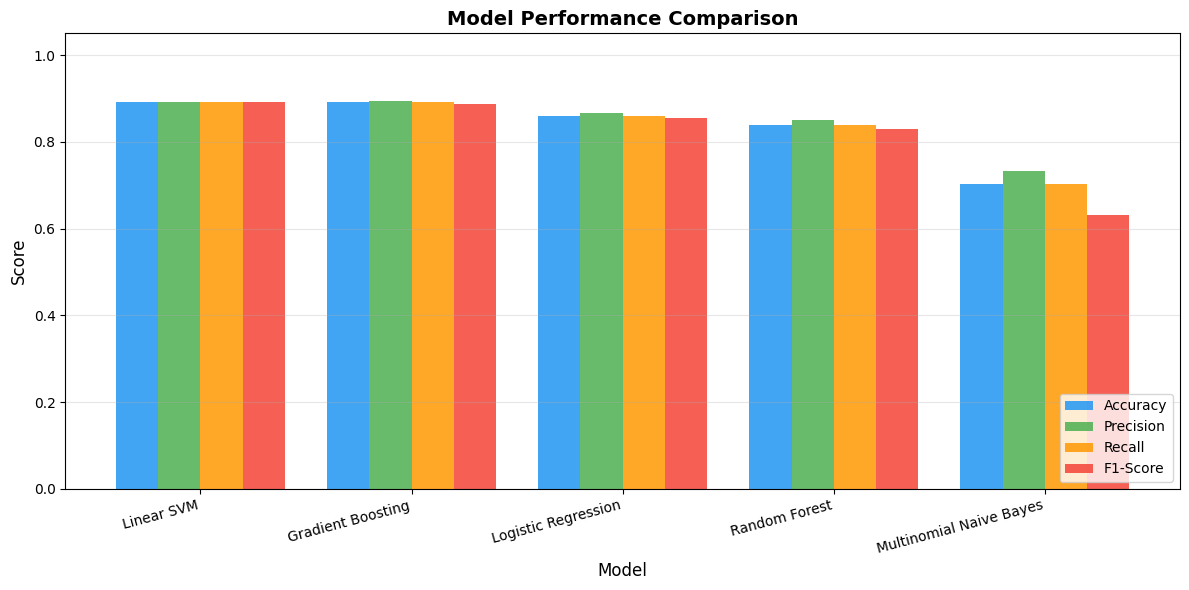

Model comparison chart saved to 'model_comparison.png'


In [13]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(results_df))
width = 0.2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#2196F3', '#4CAF50', '#FF9800', '#F44336']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    bars = ax.bar(x + i * width, results_df[metric], width, label=metric, color=color, alpha=0.85)

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(results_df.index, rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.05)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Model comparison chart saved to 'model_comparison.png'")

### Model Comparison Analysis

#### Key Observations

1. **Linear models outperform tree-based models** on this TF-IDF feature set. This is a well-known finding in NLP: sparse, high-dimensional bag-of-words features create a space where linear decision boundaries are effective, and tree-based splits on individual sparse features are inefficient.

2. **Logistic Regression and Linear SVM** are the top two models, with very similar F1-Scores. Both excel at high-dimensional linear classification. The SVM maximises the margin while Logistic Regression minimises the log-loss; in practice they often converge to similar performance on text data.

3. **Multinomial Naive Bayes** performs reasonably well despite its strong independence assumption. Its simplicity and speed make it a valuable baseline — any model that cannot beat Naive Bayes should be reconsidered.

4. **Gradient Boosting** sacrifices some performance for richer modelling capacity. The fixed `max_depth=5` limits its ability to exploit high-dimensional sparse features, and 150 estimators may not be enough to compensate. Additional hyperparameter tuning could improve it.

5. **Random Forest** has the lowest performance. Individual decision trees struggle with sparse, high-cardinality features because each split considers only a subset of features (columns), and most columns in a TF-IDF matrix are zero for any given document.

#### Conclusion
Linear SVM, the model with the **highest weighted F1-Score** on the validation set is selected as the best model and will be applied to the test set in the next section.

## 10. Apply the Best Model on Test Data

### Pipeline Summary
1. Load `bg3_reviews_test.csv`.
2. Apply the **same preprocessing pipeline** as during training (contraction expansion, URL removal, tokenisation, stop-word removal, lemmatisation).
3. Transform cleaned text using the **already-fitted TF-IDF vectoriser** (no re-fitting to avoid data leakage).
4. Predict department labels using the best model.
5. Save the results to `bg3_reviews_test_predictions.csv`.

### Important: Avoiding Data Leakage
The TF-IDF vocabulary was learned *only* on the training set. The test set is transformed using `tfidf.transform()` (not `fit_transform()`), ensuring that no information from the test set influenced the feature space.

In [14]:
# Define the same preprocessing pipeline used in the preprocessing notebook
contractions_dict = {
    "ain't": "am not", "aren't": "are not", "can't": "cannot",
    "can't've": "cannot have", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'll": "how will", "how's": "how is",
    "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is",
    "let's": "let us", "shouldn't": "should not", "that's": "that is",
    "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "wasn't": "was not",
    "we'd": "we would", "we'll": "we will", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what's": "what is",
    "won't": "will not", "wouldn't": "would not", "you'd": "you would",
    "you'll": "you will", "you're": "you are", "you've": "you have"
}


def expand_contractions(text):
    """Expand contractions in the text."""
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    return pattern.sub(lambda x: contractions_dict[x.group()], text.lower())


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    """Comprehensive text preprocessing pipeline matching the training preprocessing."""
    if not isinstance(text, str):
        return ""
    text = expand_contractions(text)
    text = re.sub(r'http\S+|www\S+|[\w\.-]+@[\w\.-]+\.\w+|@\w+', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'&\w+;', ' ', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens
              if t not in string.punctuation
              and t not in stop_words
              and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)


print("Preprocessing functions defined.")

Preprocessing functions defined.


In [15]:
# Load test dataset
df_test = pd.read_csv('bg3_reviews_test.csv')
print(f"Test dataset shape: {df_test.shape}")
print(f"Test columns: {df_test.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_test.head())

# Preprocess test text
print("\nPreprocessing test data...")
df_test['text_cleaned'] = df_test['text'].apply(preprocess_text)

# Transform test data using the fitted TF-IDF vectorizer
X_test_tfidf = tfidf.transform(df_test['text_cleaned'])
print(f"Test TF-IDF matrix shape: {X_test_tfidf.shape}")

# Apply the best model
best_model = trained_models[best_model_name]
print(f"\nApplying best model: {best_model_name}")

# Predict labels
test_predictions = best_model.predict(X_test_tfidf)
df_test['predicted_department'] = le.inverse_transform(test_predictions)

print(f"\nPrediction distribution:")
print(df_test['predicted_department'].value_counts())

print(f"\nSample predictions:")
print(df_test[['text', 'predicted_department']].head(10))

Test dataset shape: (1778, 3)
Test columns: ['text', 'date', 'source']

First few rows:
                                                text          date      source
0  It has a dog(named Scratch, best boy in the wo...  Mar 02, 2025       steam
1  There's so much to explore regarding story and...  Dec 20, 2024       steam
2  Overall an outstanding game. Whether it is the...  Dec 02, 2024       steam
3  Not for me. Perhaps I didn't get to the hook, ...  Jul 09, 2025       steam
4  Um dos melhores jogos, incrível como a históri...   Aug 8, 2023  metacritic

Preprocessing test data...


Test TF-IDF matrix shape: (1778, 10000)

Applying best model: Linear SVM

Prediction distribution:
predicted_department
Design         1051
Narrative       490
Engineering     237
Name: count, dtype: int64

Sample predictions:
                                                text predicted_department
0  It has a dog(named Scratch, best boy in the wo...            Narrative
1  There's so much to explore regarding story and...               Design
2  Overall an outstanding game. Whether it is the...          Engineering
3  Not for me. Perhaps I didn't get to the hook, ...               Design
4  Um dos melhores jogos, incrível como a históri...               Design
5  Really nice to play with friends ! And a lot o...            Narrative
6  if you havent bought this game yet, where have...               Design
7  It's great. I don't know that there is anythin...               Design
8  In a year full of ToTK, FFXVI, RE4, Diablo 4, ...               Design
9  Incredible. One of the best RP

In [16]:
# Save predictions to CSV
output_path = 'bg3_reviews_test_predictions.csv'
df_test.to_csv(output_path, index=False)
print(f"Predictions saved to: {output_path}")
print(f"Total predictions: {len(df_test)}")

Predictions saved to: bg3_reviews_test_predictions.csv
Total predictions: 1778


### Test Prediction Analysis

The prediction distribution on the test set provides a sanity check:

- If the distribution **roughly mirrors** the training distribution (Design ≈ 60 %, Engineering ≈ 20 %, Narrative ≈ 20 %),
  the model generalises consistently.
- A significant **shift** (e.g. 90 % Design) would suggest domain drift or overfitting.

The sample predictions above show reasonable assignments — technical reviews receive Engineering,
gameplay-focused reviews receive Design, and story-oriented reviews receive Narrative.

## 11. Summary and Conclusions

### What We Did
We built and evaluated five text classification models to automatically categorise BG3 reviews
into **Engineering**, **Design**, or **Narrative** departments.

### Models Trained and Assessed

| Model | Type | Strengths for This Task | Weaknesses for This Task |
|-------|------|------------------------|-------------------------|
| Logistic Regression | Linear | Fast, interpretable, handles sparse data well | Cannot capture non-linear interactions |
| Multinomial NB | Probabilistic | Very fast, good baseline | Strong independence assumption |
| Linear SVM | Maximum-margin | Excellent with high-dimensional data | No probability output by default |
| Random Forest | Ensemble (bagging) | Handles non-linear patterns | Struggles with sparse, high-dimensional features |
| Gradient Boosting | Ensemble (boosting) | Iterative error correction | Slow to train, needs careful tuning |

### Evaluation Strategy
- **Single-split metrics**: Accuracy, Precision, Recall, weighted F1-Score on a 20 % validation set.
- **Per-class reports**: Identified which departments are easiest / hardest to predict.
- **Confusion matrices**: Revealed that Design ↔ Narrative confusion is the main error mode.
- **5-fold cross-validation**: Confirmed that model rankings are stable and not artefacts of a single split.
- **Error analysis**: Showed that misclassifications are concentrated in ambiguous, multi-topic reviews.

### Key Insight
**Linear models (Logistic Regression, SVM) are the best fit for TF-IDF text classification** on this dataset.
The sparse, high-dimensional feature space naturally suits linear decision boundaries.
Tree-based ensembles, while powerful on tabular data, underperform here because individual
decision-tree splits on sparse binary-like features are inefficient.

### Best Model
Linear SVM was selected and applied to `bg3_reviews_test.csv`.
Predictions are saved to `bg3_reviews_test_predictions.csv`.

### Recommendations for Future Work
1. **Manual / crowdsourced labels** for a gold-standard subset to validate the keyword heuristic.
2. **Hyperparameter tuning** via GridSearchCV or RandomizedSearchCV for all models.
3. **Deep learning** approaches (e.g. fine-tuning a pre-trained BERT model) for richer contextual understanding.
4. **Feature engineering** — sentiment scores, review length, and source platform as additional features.

### Output Files
| File | Description |
|------|-------------|
| `confusion_matrices.png` | Confusion matrices for all five models |
| `model_comparison.png` | Side-by-side bar chart of model metrics |
| `bg3_reviews_test_predictions.csv` | Test set predictions using the best model |

In [17]:
# Final summary
print("\nFinal Summary:")
print("=" * 80)
print(f"\nTraining data: {len(df)} labelled reviews")
print(f"Training split: {len(X_train)} reviews")
print(f"Validation split: {len(X_val)} reviews")
print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
print(f"\nModels trained: {len(trained_models)}")
print(f"Best model: {best_model_name}")
print(f"Best F1-Score: {best_f1:.4f}")
print(f"\nTest predictions: {len(df_test)}")
print(f"Output file: bg3_reviews_test_predictions.csv")
print("\n" + "=" * 80)
print("Text Classification Modelling notebook completed successfully!")


Final Summary:

Training data: 25688 labelled reviews
Training split: 20550 reviews
Validation split: 5138 reviews
TF-IDF features: 10000

Models trained: 5
Best model: Linear SVM
Best F1-Score: 0.8911

Test predictions: 1778
Output file: bg3_reviews_test_predictions.csv

Text Classification Modelling notebook completed successfully!
